In [57]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

In [58]:
class Agent:
    def __init__(self, name, position, q_table, alpha, gamma, epsilon):
        # Initialize variables with provided values
        self.name = name
        self.position = position
        self.q_table = q_table
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.world_bounds = (3,3,3)

        # Initialize variables that track agent actions
        self.prev_state = None
        self.prev_action = None
        self.prev_reward = None
        self.carrying = None

    def reset(self):
        # Reset all states and rewards
        self.prev_reward = None
        self.prev_action = None
        self.prev_state = None
        self.carrying = None

    # Following functions move agent accordingly; checks if action is valid before moving
    def North(self):
        new_pos = (self.position[0], self.position[1] + 1, self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def East(self):
        new_pos = (self.position[0] + 1, self.position[1], self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def South(self):
        new_pos = (self.position[0], self.position[1] - 1, self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def West(self):
        new_pos = (self.position[0] - 1, self.position[1], self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def Up(self):
        new_pos = (self.position[0], self.position[1], self.position[2] + 1)
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def Down(self):
        new_pos = (self.position[0], self.position[1], self.position[2] - 1)
        if self.is_valid_position(new_pos):
            self.position = new_pos

    # Checks
    def is_valid_position(self, position):
        return all(0 <= coord < bound for coord, bound in zip(position, self.world_bounds))

    def pickup(self):
        print()
        # TODO implement function

    def dropoff(self):
        print()
        # TODO implement function

In [59]:
class PDWorld:
    # Set up world for agents
    def __init__(self, size=(3, 3, 3), blocks=None, dropoffs=None):
        self.size = size
        self.blocks = {} if blocks is None else blocks
        self.dropoffs = {} if dropoffs is None else dropoffs

    def is_valid_position(self, position):
        return all(0 <= coord < bound for coord, bound in zip(position, self.size))

    # Returns value of block at given position
    def get_block(self, position):
        return self.blocks.get(position)

    # Sets value of block
    def set_block(self, position, value):
        self.blocks[position] = value

    # Removes block at given position
    def remove_block(self, position):
        self.blocks.pop(position, None)

    # Determine what actions agent can take
    def get_valid_actions(self, agent_pos, agent_holding):
        valid_actions = []

        # Agent can always stay in place
        valid_actions.append('stay')

        # Check if agent can move north
        if self.is_valid_position((agent_pos[0], agent_pos[1]+1, agent_pos[2])):
            valid_actions.append('north')

        # Check if agent can move east
        if self.is_valid_position((agent_pos[0]+1, agent_pos[1], agent_pos[2])):
            valid_actions.append('east')

        # Check if agent can move south
        if self.is_valid_position((agent_pos[0], agent_pos[1]-1, agent_pos[2])):
            valid_actions.append('south')

        # Check if agent can move west
        if self.is_valid_position((agent_pos[0]-1, agent_pos[1], agent_pos[2])):
            valid_actions.append('west')

        # Check if agent can move up
        if self.is_valid_position((agent_pos[0], agent_pos[1], agent_pos[2]+1)):
            valid_actions.append('up')

        # Check if agent can move down
        if self.is_valid_position((agent_pos[0], agent_pos[1], agent_pos[2]-1)):
            valid_actions.append('down')

        # Check if agent can pick up a block
        if not agent_holding and agent_pos in self.blocks:
            valid_actions.append('pickup')

        # Check if agent can drop off a block
        if agent_holding and agent_pos in self.dropoffs and self.dropoffs[agent_pos] == agent_holding:
            valid_actions.append('dropoff')

        return valid_actions

    def plot_world(self, agents=None):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Set limits for the plot
        ax.set_xlim3d(0, self.size[0])
        ax.set_ylim3d(0, self.size[1])
        ax.set_zlim3d(0, self.size[2])

        # Plot the blocks
        for position, value in self.blocks.items():
            x, y, z = position
            color = 'r' if value is None else 'b'
            ax.scatter(x, y, z, c=color, marker='s')

        # Plot the dropoffs
        for position in self.dropoffs.keys():
            x, y, z = position
            ax.scatter(x, y, z, c='g', marker='o')

        # Plot the agents
        if agents is not None:
            for agent in agents:
                x, y, z = agent.position
                ax.scatter(x, y, z, c='k', marker='^')

        plt.show()


In [60]:
class QTable:
    def __init__(self):
        self.table = {}

    # Returns q value for given state action pair from q table; default value is 0 if pair isnt present
    def get(self, state, action):
        return self.table.get((state, action), 0.0)

    # Updates q value for given state action pair with given value
    def update(self, state, action, value):
        self.table[(state, action)] = value

    # Returns action with highest q value for given state among list of actions; Randomizes action if there are multiple highest values
    def get_best_action(self, state, actions):
        q_values = {a: self.get(state, a) for a in actions}
        max_q = max(q_values.values())
        actions_with_max_q = [a for a, q in q_values.items() if q == max_q]
        return random.choice(actions_with_max_q)

In [61]:
# Additional functions
def prevent_collision(agent1, agent2):
    # Agents are at the same position, so move one of them randomly
    if agent1.position == agent2.position:
        possible_moves = ['North', 'East', 'South', 'West', 'Up', 'Down']
        random_move = random.choice(possible_moves)
        if random_move == 'North':
            agent1.North()
        elif random_move == 'East':
            agent1.East()
        elif random_move == 'South':
            agent1.South()
        elif random_move == 'West':
            agent1.West()
        elif random_move == 'Up':
            agent1.Up()
        elif random_move == 'Down':
            agent1.Down()

def reward(prev_state, prev_action, state, blocks):
    reward = 0
    if prev_action in state['valid_actions']:
        if state['agent_holding'] is not None:
            # Agent has dropped off a block at a valid dropoff position
            if blocks.get(state['agent_position']) == state['agent_holding']:
                reward += 14
            else:
                reward -= 5
        else:
            # Agent has moved to a new position without transporting a block
            reward -= 1
            if state['agent_position'] in blocks and blocks[state['agent_position']] is not None:
                # Agent has picked up a block from a valid pickup position
                if prev_state is not None and blocks.get(prev_state['agent_position']) != state['agent_holding']:
                    # Penalize agent for picking up block unnecessarily
                    reward -= 5
                else:
                    reward += 14

    else:
        # Agent has attempted an invalid action (e.g. moving out of bounds or into a wall)
        reward -= 1

    return reward


In [62]:
 # initializing world
WORLD_SIZE = 3 # alter as necessary
world = PDWorld(size=(WORLD_SIZE, WORLD_SIZE, WORLD_SIZE))
agents = []


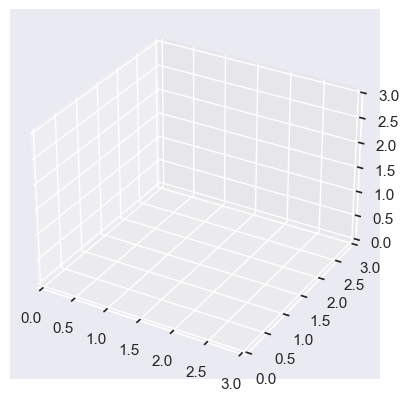

In [63]:
world.plot_world()